In [1]:
sc

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
from pyspark.mllib.recommendation import ALS
from pyspark.sql.functions import col
import math
import random
import itertools
import copy
from joblib import Parallel, delayed
import multiprocessing
import pickle
import scipy.optimize as sco

from cross_validation import KFoldIndexes,CrossValidation
from cross_validation_blending import CrossValidationBlending
from models.als import predictions_ALS
from models.means import *
from models.medians import *
from models.helpers import *
from models.collaborative_filtering import *
from models.MF_SGD import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 100
sc.setCheckpointDir('./checkpoint/')


ImportError: No module named 'rescaler'

In [3]:
dic = {'coucou': 4, 'coucou2' : 6}

In [5]:
for i in dic.keys():
    print(i)

coucou
coucou2


In [15]:
list(dic.values())[0]

4

In [3]:
train = load_csv()
train.head()

,User,Movie,Rating
0,44,1,4
1,61,1,3
2,67,1,4
3,72,1,3
4,86,1,5


In [4]:
models = {
    'global_mean': {
        'compute_predictions': True,
        'function': global_mean,
        'params': {}    
    },
    'user_mean': {
        'compute_predictions': True,
        'function': user_mean,
        'params': {}
    },
    'movie_mean': {
        'compute_predictions': True,
        'function': movie_mean,
        'params': {}
    },
    'global_median': {
        'compute_predictions': True,
        'function': global_median,
        'params': {}    
    },  
    'user_median': {
        'compute_predictions': True,
        'function': user_median,
        'params': {}
    },
    'movie_median': {
        'compute_predictions': True,
        'function': movie_median,
        'params': {}
    }
}

models2 = {
    'movie_mean_deviation_user': {
        'compute_predictions': True,
        'function': movie_mean_deviation_user,
        'params': {}
    },
    'movie_median_deviation_user': {
        'compute_predictions': True,
        'function': movie_median_deviation_user,
        'params': {}
    }
}

models3 = {
    'als': {
        'compute_predictions': True,
        'function': predictions_ALS,
        'params': {
            'spark_context': sc,
            'rank': 8,
            'lambda_': 0.081, 
            'iterations': 24, 
            'nonnegative': True
        }
    },
    'collab_filt': {
        'compute_predictions': True,
        'function': collaborative_filtering,
        'params': {
            'movie_features':20, 
            'alpha':19
        }  
    },
    'mf_sgd': {
        'compute_predictions': True,
        'function': matrix_factorization_SGD,
        'params': {
            'gamma': 0.004,
            'n_features': 20,
            'n_iter': 20,
            'init_method': 'global_mean'
        }
    }
}

models4 = {
    'global_mean': {
        'compute_predictions': True,
        'function': global_mean,
        'params': {}    
    },  
    'mf_sgd': {
        'compute_predictions': True,
        'function': matrix_factorization_SGD,
        'params': {
            'gamma': 0.004,
            'n_features': 20,
            'n_iter': 20,
            'init_method': 'global_mean'
        }
    }   
}

# add by Jo
models5 = {
        'mf_sgd_rescale': {
        'compute_predictions': True,
        'function': matrix_factorization_SGD_rescaling,
        'params': {
            'gamma': 0.004,
            'n_features': 20,
            'n_iter': 20,
            'init_method': 'global_mean'
        }
    }
}

models = dict(models, **models2)

models = dict(models, **models3)

# add by Jo
models = dict(models, **models5)

In [5]:
def prepare_blending(data, k_folds, models):
    blending = CrossValidationBlending(data, k_folds)
    for key in models.keys():
        blending.add_model(models[key]['function'], key)
    return blending

def add_param_blending(blending, models):
    for key in models.keys():
        blending.add_params_for_model(key, models[key]['params'], compute_predictions=models[key]['compute_predictions'])
        
    return blending

def test_blending(blending, best_dict, models):
    dict_try = {}
    for key in models.keys():
        dict_try[key] = 0
        
    for key in models.keys():
        dict_test = dict_try.copy()
        dict_test[key] = 1
        rmse = blending.evaluate_blending(dict_test)
        print("RMSE for model %s: %.5f"%(key, rmse))
        
    print()
    rmse = blending.evaluate_blending(best_dict)
    print("Best blending: %s"%best_dict)
    print("RMSE best blending: %.5f"%rmse)
    
def prediction(train, blending, best_dict, output):
    test = pd.read_csv('../data/sampleSubmission.csv')
    test_prep = test
    test_prep['User'] = test_prep['Id'].apply(lambda x: int(x.split('_')[0][1:]))
    test_prep['Movie'] = test_prep['Id'].apply(lambda x: int(x.split('_')[1][1:]))
    test_prep['Rating'] = test_prep['Prediction']
    test_prep = test_prep.drop(['Prediction', 'Id'], axis=1)
    
    pred = blending.evaluate_blending_for_validation(best_dict, train, test_prep)
    for i in range(len(pred)):
        if pred[i] > 5:
            pred[i] = 5
        elif pred[i] < 1:
            pred[i] = 1
    
    test.Rating=pred
    test['Prediction']=test.Rating
    test = test.drop(['User', 'Movie', 'Rating'], axis=1)
    test.to_csv(output, index=False)
    
def eval_(x, blending, models):
    dict_try = {}
    for idx, key in enumerate(models.keys()):
        dict_try[key] = x[idx] 
        
    return blending.evaluate_blending(dict_try)

In [6]:
blending = prepare_blending(train, 0, models)

In [7]:
blending = add_param_blending(blending, models)

[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9881823330973184
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9888665117215252
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.988032696198208
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9882358187270177
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9885613620582535
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9896312575084751
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.990308439228692
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterati

/Users/joachimmuth/Documents/EPFL/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:61: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Udata = train.set_index('Movie').join(M).sort('User').set_index('User')
/Users/joachimmuth/Documents/EPFL/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:90: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Mdata = train.set_index('User').join(U).sort('Movie').set_index('Movie')


[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done
[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done
[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done
[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done
[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done


In [8]:
x0 = np.zeros(len(models.keys()))
x0[0]=1
eval_(x0, blending, models)

1.09519862793485

In [12]:
models.keys()

dict_keys(['user_mean', 'mf_sgd_rescale', 'mf_sgd', 'als', 'movie_mean_deviation_user', 'movie_median', 'movie_mean', 'movie_median_deviation_user', 'user_median', 'collab_filt', 'global_median', 'global_mean'])

In [13]:
# x0 = [-3.50217241, -0.34302467,  1.03720384, -0.32505441, -4.12058282,
#         0.61916421,  4.08423545, -0.02151008,  0.06576934,  3.88763932,
#        -0.51662585]

x0 = [-3.50217241, -0.17, -0.17,  1.03720384, -0.32505441, -4.12058282,
        0.61916421,  4.08423545, -0.02151008,  0.06576934,  3.88763932,
       -0.51662585]
res = sco.minimize(eval_, x0, method='Nelder-Mead', args=(blending, models), options={'maxiter':1000, 'disp':True})

In [14]:
res

 final_simplex: (array([[-3.67733253, -0.06728784, -0.0386203 ,  0.89273835, -0.4326688 ,
        -4.29733004,  0.58294735,  4.29873608, -0.00498556,  0.07109685,
         4.16579753, -0.64503052],
       [-3.67668175, -0.0672939 , -0.03871486,  0.89252079, -0.43169848,
        -4.29645175,  0.58257805,  4.29762429, -0.00481035,  0.07107838,
         4.16302734, -0.64299572],
       [-3.67698695, -0.06687656, -0.03883351,  0.89257757, -0.43152897,
        -4.29699774,  0.58262729,  4.29800586, -0.00505886,  0.07066465,
         4.1633293 , -0.64277033],
       [-3.67638212, -0.06752715, -0.03878493,  0.89259771, -0.4317922 ,
        -4.29665143,  0.58278727,  4.29780694, -0.00495888,  0.0709262 ,
         4.16331042, -0.6431626 ],
       [-3.67804203, -0.06701696, -0.03816157,  0.89253696, -0.43355941,
        -4.29886145,  0.58296496,  4.30044059, -0.00518296,  0.07101605,
         4.1688766 , -0.64706042],
       [-3.67653582, -0.06739016, -0.03870795,  0.89245872, -0.43162301,
     

In [15]:
dict_opt = {}
for idx, key in enumerate(models.keys()):
    dict_opt[key] = res.x[idx]
dict_opt

{'als': 0.89273834619373038,
 'collab_filt': 0.071096854713773971,
 'global_mean': -0.6450305175665445,
 'global_median': 4.1657975331095347,
 'mf_sgd': -0.038620299655287627,
 'mf_sgd_rescale': -0.067287844047187018,
 'movie_mean': 0.58294734803419068,
 'movie_mean_deviation_user': -0.43266880016189613,
 'movie_median': -4.2973300370745839,
 'movie_median_deviation_user': 4.2987360771658558,
 'user_mean': -3.6773325300577424,
 'user_median': -0.0049855566007924942}

In [16]:
test_blending(blending, dict_opt, models)

RMSE for model user_mean: 1.09520
RMSE for model mf_sgd_rescale: 0.99981
RMSE for model mf_sgd: 1.00052
RMSE for model als: 0.98861
RMSE for model movie_mean_deviation_user: 0.99653
RMSE for model movie_median: 1.09963
RMSE for model movie_mean: 1.03045
RMSE for model movie_median_deviation_user: 1.05793
RMSE for model user_median: 1.15163
RMSE for model collab_filt: 1.02733
RMSE for model global_median: 1.12812
RMSE for model global_mean: 1.11906

Best blending: {'user_mean': -3.6773325300577424, 'mf_sgd_rescale': -0.067287844047187018, 'mf_sgd': -0.038620299655287627, 'als': 0.89273834619373038, 'movie_mean_deviation_user': -0.43266880016189613, 'movie_median': -4.2973300370745839, 'movie_mean': 0.58294734803419068, 'movie_median_deviation_user': 4.2987360771658558, 'user_median': -0.0049855566007924942, 'collab_filt': 0.071096854713773971, 'global_median': 4.1657975331095347, 'global_mean': -0.6450305175665445}
RMSE best blending: 0.96277


In [19]:
# i don't know if it works... to clear sp context order to avoid error in 'prediction' method
sqlContext = SQLContext.getOrCreate(SparkContext.getOrCreate())

sqlContext.clearCache()

In [20]:
prediction(train, blending, dict_opt, 'pred_blending.csv')

[USER_MEAN] applying
[USER_MEAN] done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9895411617478957
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9908975630629757
[MF-SGD] Done
[ALS] applying


Py4JJavaError: An error occurred while calling o875.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1647.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1647.0 (TID 4272, localhost): TaskResultLost (result lost from block manager)
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1454)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1442)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1441)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1441)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1667)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1622)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1611)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:632)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1873)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1886)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1899)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1913)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:912)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:358)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:911)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:290)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:2526)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2523)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2523)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2546)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2523)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)


In [31]:
df = pd.read_csv('pred_blending_Jo.csv')
df.head()


,Id,Prediction
0,r37_c1,3.283646
1,r73_c1,3.175412
2,r156_c1,3.805759
3,r160_c1,3.381214
4,r248_c1,3.702791


In [32]:
pred = list(df.Prediction)

(array([  5.00000000e+01,   9.20000000e+01,   1.94000000e+02,
          5.07000000e+02,   1.26600000e+03,   2.75100000e+03,
          5.68900000e+03,   1.06040000e+04,   1.98780000e+04,
          3.41270000e+04,   5.71770000e+04,   8.86940000e+04,
          1.23696000e+05,   1.54814000e+05,   1.74385000e+05,
          1.73022000e+05,   1.47484000e+05,   1.02678000e+05,
          5.39810000e+04,   2.58630000e+04]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,
         3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ]),
 <a list of 20 Patch objects>)

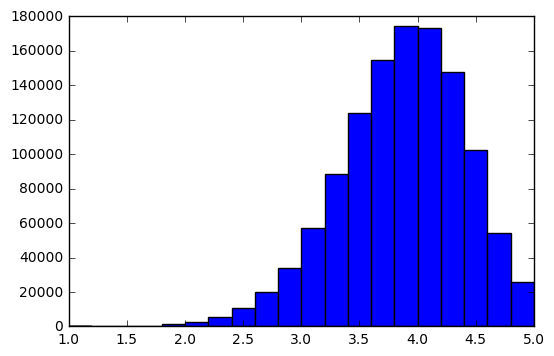

In [33]:
plt.hist(pred, bins=20)